# 04_ZTM_Pytorch Custom Datasets

We've used some datasets with PyTorch before but how do you get your own data
on PyTorch.

One of the ways to do so is via custom datasets.

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.


## 0. Importing PyTorch and setting up device-agnostic code

In [2]:
# Import dependencies
import torch
from torch import nn

# Note: PyTorch 1.10.0 + is required for this course
print(torch.__version__)

2.2.1+cu121


In [3]:
# Setting up device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get data

Our dataset is the subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing)

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup a directory for data
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exists, download ith and prepare it...
if image_path.is_dir():
  print(f'{image_path} directory already exists... skipping download.')
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents = True, exist_ok = True)

# Download the data
if Path(image_path / 'pizza_steak_sushi.zip').is_file():
  print('File already exists skipping download')
else:
  with open(image_path/ 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print('Downloading the file..')
    f.write(request.content)

# Extract the contents of the file
with zipfile.ZipFile(image_path/'pizza_steak_sushi.zip', 'r') as zipref:
  print('Unzipping pizza, steak and sushi data...')
  zipref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data ( data preparation and data exploration)

In [5]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} and {len(filenames)} in directory {dirpath}')

In [6]:
# View the directories and files in each of the directories
walk_through_dir(image_path)

There are 2 and 1 in directory data/pizza_steak_sushi
There are 3 and 0 in directory data/pizza_steak_sushi/test
There are 0 and 31 in directory data/pizza_steak_sushi/test/sushi
There are 0 and 25 in directory data/pizza_steak_sushi/test/pizza
There are 0 and 19 in directory data/pizza_steak_sushi/test/steak
There are 3 and 0 in directory data/pizza_steak_sushi/train
There are 0 and 72 in directory data/pizza_steak_sushi/train/sushi
There are 0 and 78 in directory data/pizza_steak_sushi/train/pizza
There are 0 and 75 in directory data/pizza_steak_sushi/train/steak


In [7]:
# Setup train and testing path
train_dir = image_path /'train'
test_dir = image_path /'test'

test_dir, train_dir

(PosixPath('data/pizza_steak_sushi/test'),
 PosixPath('data/pizza_steak_sushi/train'))

### 2.1 Visualizing images

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL.
5. We'll then show the image and print metadata.


In [8]:
import random
from PIL import Image

# Define a function to randomly pick an image from the dataset and view it

def plot_random_images(dir_path):

  """Returns an image and its associated class name by randomly picking the image from the dataset

    Args:
      dir_path (str): It takes in data path as a input to pick and view the images
  """

  # 1. Get all the image paths
  paths = []
  for path in Path(dir_path).glob('*/*/*.jpg'):
    paths.append(path)

  # 2. Pick a random image from the path
  random_image_path = random.choice(paths)

  # 3. Get the image class from the path name (the image class os the name of the directory)
  class_name = random_image_path.parent.stem

  # Open image
  img = Image.open(random_image_path)

  # 5. Print metadata
  print(f'Random image path: {random_image_path}')
  print(f"Image class: {class_name}")
  print(f"Image height: {img.height}")
  print(f"Image width: {img.width}")

  return img, class_name

Random image path: data/pizza_steak_sushi/train/pizza/853441.jpg
Image class: pizza
Image height: 512
Image width: 384


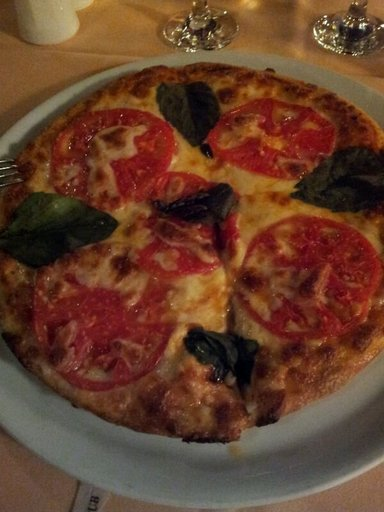

In [9]:
# Let's print the image randomly from our dataset
img, label = plot_random_images(image_path)
img

Image path: data/pizza_steak_sushi/test/steak/100274.jpg
Image -> (height, width, color_channels): (384, 512, 3)


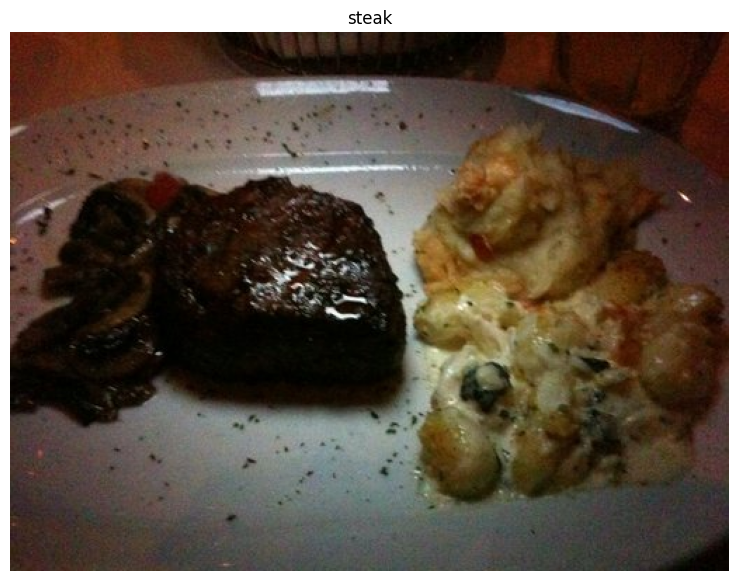

In [10]:
# Visualizing random image using matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

paths = []
for path in Path(image_path).glob('*/*/*.jpg'):
  paths.append(path)

# 2. Pick a random image from the path
plt.figure(figsize = (10,7))
random_image_path = random.choice(paths)
image = mpimg.imread(random_image_path)
print(f'Image path: {random_image_path}\nImage -> (height, width, color_channels): {image.shape}')
plt.imshow(image)
plt.title(random_image_path.parent.stem)
plt.axis(False)
plt.show()

Image -> (height, width, color_channels): (512, 384, 3)


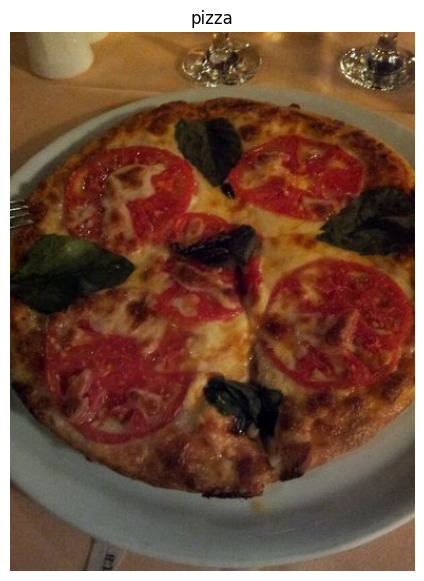

In [11]:
# OR
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.array(img)

# 2. Pick a random image from the path
plt.figure(figsize = (10,7))
print(f'Image -> (height, width, color_channels): {img_as_array.shape}')
plt.imshow(img_as_array)
plt.title(label)
plt.axis(False)
plt.show()

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).

2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation.

In [13]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to (64, 64)
    transforms.Resize(size = (64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p = 0.5),
    # Turn theimage into a torch.tensor
    transforms.ToTensor()
])

In [14]:
data_transform(img).dtype

torch.float32

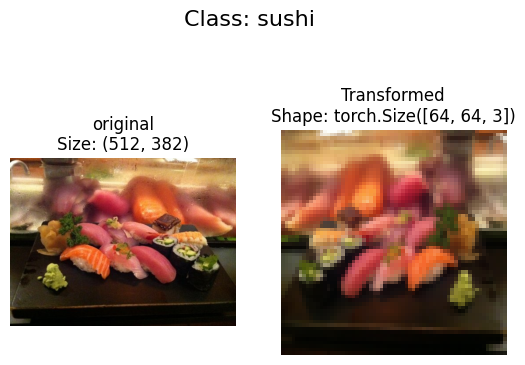

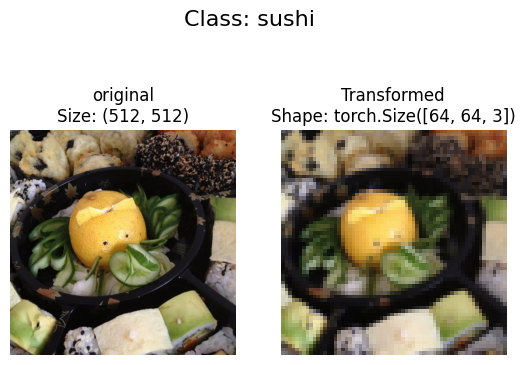

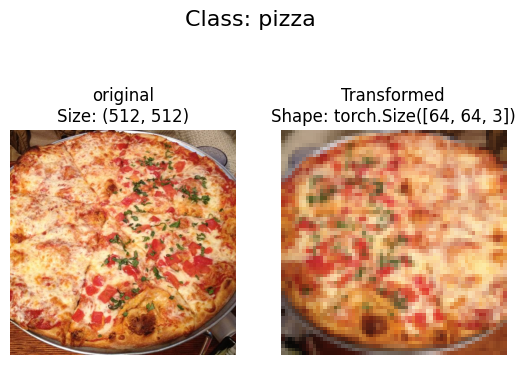

In [15]:
def plot_transformed_images(image_paths, transform, n = 3, seed = None):
  """
  Selects random images from a path of images and loads/transforms them then
  plots the original vs. the transformed version.
  """
  if seed:
    random.seed(seed)
  # Randomly pick 3 image paths
  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f"original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis('off')

      fig.suptitle(f'Class: {image_path.parent.stem}', fontsize = 16)

plot_transformed_images(image_paths = paths,
                        transform = data_transform,
                        n = 3,
                        seed = None)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [16]:
# Use ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform, # A transform for the data
                                  target_transform = None) # A transform for labels

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform,
                                 target_transform = None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [20]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [21]:
# Index on the train data dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f"image labels: {label}")
print(f"Label datatype: {type(label)} ")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

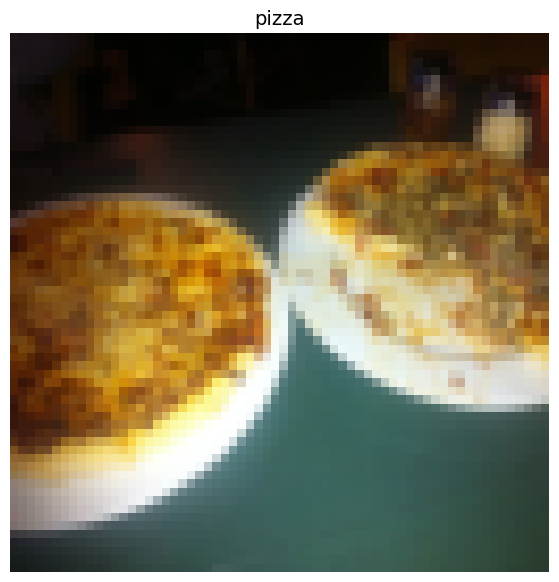

In [22]:
# Rearrange the order dimensions
img_permute = img.permute(1,2,0) # H, W, C

# Print our different shapes
print(f'Original shape: {img.shape} -> [color_channels, height, width]')
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize = (10,7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label], fontsize = 14)

### 4.1. Turn loaded images into dataloader using `torch.utils.data.DataLoader`

A dataloader is going to help us turn our `Dataset` s into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time.

In [23]:
# Turn train and test datasets into Data Loaders
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = 1, # How many cores you want to assign os.cpu_count()
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 1,
                             shuffle = False)

len(train_dataloader), len(test_dataloader)

(225, 75)

In [24]:
img, label = next(iter(train_dataloader))

# Batch size will now be one
print(f'Image shape: {img.shape} -> [color_channels, height, width]')
print(f'Label shape: {label.shape}')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Image shape: torch.Size([1, 3, 64, 64]) -> [color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading image data witha custom `Dataset`

1. Want to be able to load images from the file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work..
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues.

All custom datasets in PyTorch, often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [25]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [26]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to tranverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the classnames aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and list and return them.

In [27]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [28]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"couldn't find any classes in {directory}.. Please check file structure.")

  # 3. Create a dictionary of index labels (computers prefer number rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [29]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a trget directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len__()` method to return the length of our dataset.
6. Overwrite the `__getitem()__` method to return a given sample when passed an index





In [30]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our sutom dataset
  def __init__(self,
               targ_dir:str,
               transform = None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
    # Setup transforms
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    """Opens an image via a path and returns it."""
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    """Returns the total number of samples"""
    return len(self.paths)

  # 6. Overwrite __getitem__() to return a particular sample
  def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
    """Returns one sample of data, data and label (X, y)."""
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X,y)
    else:
      return img, class_idx # Return untransformed data, label

In [31]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

In [32]:
# Test out ImageFolder custom
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform = train_transforms)

test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                      transform = test_transforms)

In [33]:
train_data_custom

In [34]:
test_data_custom

In [35]:
len(train_data_custom)

225

In [36]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [37]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [38]:
# Check for equality between original ImageFolder dataset and ImageFolderCustom dataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility.
4. Get a list of random sample of indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample images and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib (HWC).


In [39]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed : int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print("For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k = n)

  # 5. Setup plot
  plt.figure(figsize=(16,8))

  # 6. Loop thriugh random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis('off')
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

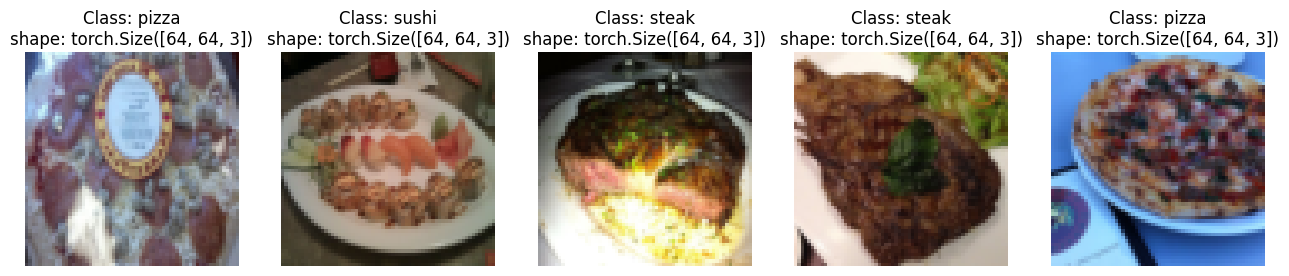

In [40]:
# Display random images from the ImageFolder created dataset
display_random_images(train_data,
                      n = 5,
                      classes = class_names,
                      seed = None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


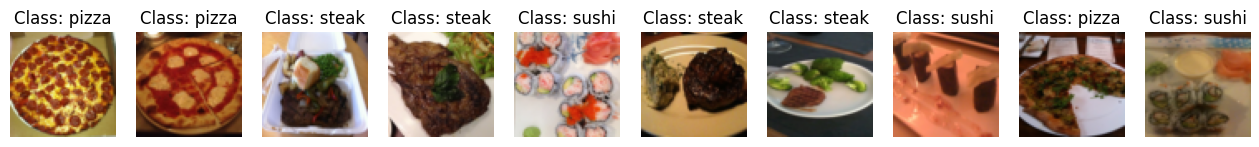

In [41]:
# Display random images from the ImageFolderCustom dataset
display_random_images(train_data_custom,
                      n =20,
                      classes = class_names,
                      seed = None)

### 5.4 Turn Custom loaded images into data loaders

In [42]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = 1
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                     batch_size = BATCH_SIZE,
                                     num_workers = NUM_WORKERS,
                                     shuffle = True)

test_dataloader_custom = DataLoader(dataset = test_data_custom,
                                    batch_size = BATCH_SIZE,
                                    num_workers = NUM_WORKERS,
                                    shuffle = False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f5985e01330>,
 <torch.utils.data.dataloader.DataLoader at 0x7f5985e02020>)

In [43]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shape
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Data Augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels ...

Blog post : https://pytorch.org/vision/main/generated/torchvision.transforms.TrivialAugmentWide.html

In [44]:
# Let's look at Trivial Augment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size= (224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins= 5), # max = 31
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size= (224,224)),
    transforms.ToTensor()
])

In [45]:
# Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/sushi/499605.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2521706.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/207578.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1680893.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1245193.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/887831.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/858157.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/684266.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/175783.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2540511.jpg')]

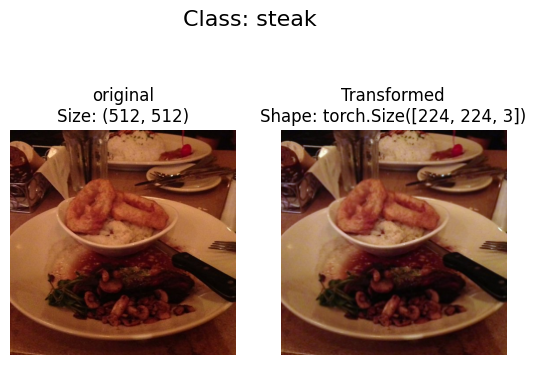

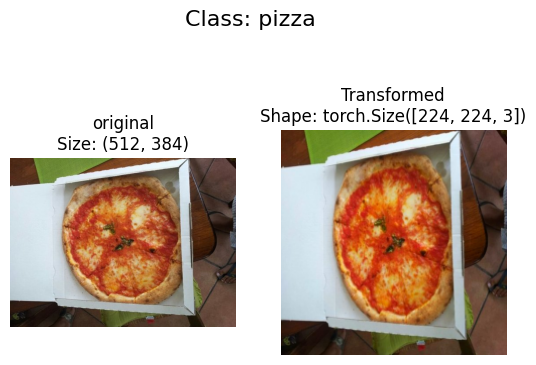

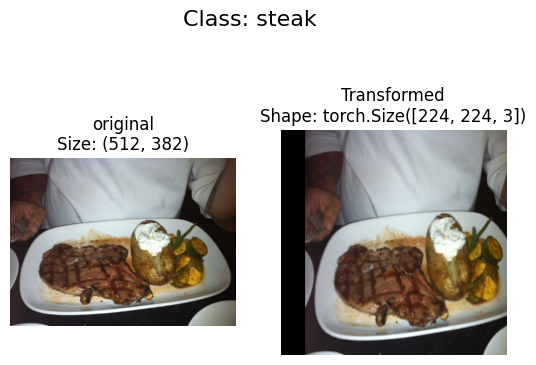

In [46]:
# Plot random transformed images
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transform,
    n = 3,
    seed = None
)

## 7. Model 0: TinyVGG without data augmentation

Let's replicate TinyVGG architecture from the CNN explainer website:
https://poloclub.github.io/cnn-explainer/

### 7.1: Creating transforms and loading data for Model 0

In [47]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

In [48]:
# 1. Load and Transform image data using ImageFolder class
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root = train_dir,
                                         transform = simple_transform,
                                         target_transform=None)

test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform = simple_transform,
                                        target_transform=None)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset = train_data_simple,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True,
                                     num_workers = NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle = False,
                                    num_workers = NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7f5985c7b310>,
 <torch.utils.data.dataloader.DataLoader at 0x7f5985de3f70>)

### 7.2 Create TinyVGG model class

In [49]:
class TinyVGG(nn.Module):
  """Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/"""
  def __init__(self,
               input_shape : int,
               hidden_units : int,
               output_shape : int) -> None:
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2) # default stride value is same as kernel size
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2) # default stride value is same as kernel size
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*13*13,
                  out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)

    return x
    # return self.classifier(self.conv_block_1(self.conv_block_2(x))) # benefits from operator fusion

torch.manual_seed(42)
# Instantiate the model
model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [50]:
# Create a dummy tensor of shape  (64 * 64 * 3)
random_tensor = torch.randn((3 , 64 , 64)).type(torch.float).unsqueeze(dim = 0).to(device)
random_tensor.shape

torch.Size([1, 3, 64, 64])

In [51]:
model_0(random_tensor)

tensor([[ 0.0216, -0.0143, -0.0036]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [52]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [53]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.4284e-02, -4.2103e-03,  9.1338e-03],
        [ 2.0510e-02, -7.8605e-04,  8.4659e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2792e-02, -2.7526e-03,  1.1189e-02],
        [ 1.8338e-02,  1.6959e-04,  6.0050e-03],
        [ 2.1927e-02, -1.7779e-03,  8.1963e-03],
        [ 2.2926e-02, -1.4961e-03,  1.0282e-02],
        [ 2.0046e-02,  4.5708e-04,  1.0549e-02],
        [ 2.0898e-02,  1.3277e-04,  8.8580e-03],
        [ 1.9509e-02,  7.8303e-04,  8.2038e-03],
        [ 1.9482e-02, -2.1679e-03,  9.9535e-03],
        [ 1.9283e-02, -5.5838e-03,  1.2924e-02],
        [ 2.0974e-02, -4.5354e-03,  8.4500e-03],
        [ 2.2059e-02, -4.6367e-03,  1.2652e-02],
        [ 2.0805e-02,  1.9377e-04,  9.1865e-03],
        [ 2.1532e-02, -6.0485e-04,  7.3696e-03],
        [ 2.4643e-02, -3.2281e-03,  8.6759e-03],
        [ 1.9826e-02, -3.8645e-03,  9.8465e-03],
        [ 2.1256e-02, -1.6102e-03,  9.5531e-03],
        [ 1.8828e-02, -4.1590e-04,  8.5030e-03],
        [ 2.1695e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model


https://github.com/TylerYep/torchinfo

In [54]:
# Install torchinfo, import it if it's available
try:
  import torchinfo

except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size = [1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 7.5 Create train and test loop functions

* `train_step()` - takes in a model and a dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [55]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader : torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device):
  # Put the model in train mode
  model.train()

  # Setup train and loss accuracy value
  train_loss, train_acc = 0, 0

  # Loop through dataloader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward Pass
    y_pred = model_0(X) # outputs model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss Backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metrics
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get the average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [98]:
# Create test_step()
def test_step(model: torch.nn.Module,
              dataloader : torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device = device):
  # Put the model in eval mode
  model.eval()

  # Setup test and loss accuracy value
  test_loss, test_acc = 0, 0

  # Turn on the inference mode
  with torch.inference_mode():
    # Loop through dataloader and data batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward Pass
      test_pred_logits = model_0(X) # outputs model logits

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate accuracy metrics
      test_pred_labels = test_pred_logits.argmax(dim = 1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get the average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

  return test_loss, test_acc

### 7.6  Creating `train()` function to combine `train_step()` and `test_step()`

In [66]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloader + loss function
def train(model : torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn : torch.nn.Module = nn.CrossEntropyLoss(),
          epochs : int = 5,
          optimizer : torch.optim.Optimizer = None,
          device = device,
          step : str = None
          ):

  # 2. Create empty results dictionary
  results = {'train_loss' : [],
             'train_acc' : [],
             'test_loss' :[],
             'test_acc' : []}

  # 3. Loop through training and testing steps for a number fo epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device)
    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader,
                                    loss_fn = loss_fn,
                                    device = device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update our results dictionary
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

    # 6. Return the filled results at the end of the epochs
  return results

### 7.7 Train and evaluate model 0



In [86]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVgg
model_0 = TinyVGG(input_shape = 3, # No of color channels
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr = 0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model = model_0,
                        train_dataloader = train_dataloader_simple,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)

# End the time and print out how long it took
end_time = timer()

print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test acc: 0.3011
Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.0869 | Train acc: 0.4883 | Test acc: 0.4924
Epoch: 3 | Train loss: 1.0843 | Train acc: 0.4023 | Test acc: 0.5833
Epoch: 4 | Train loss: 1.0662 | Train acc: 0.4102 | Test acc: 0.5644
Total training time: 4.993 seconds


In [87]:
model_0_results

{'train_loss': [1.1063191294670105,
  1.0998025238513947,
  1.0868679285049438,
  1.0843235850334167,
  1.066220760345459],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.40234375, 0.41015625],
 'test_loss': [1.0983209212621052,
  1.069698969523112,
  1.08075749874115,
  1.0607813199361165,
  1.0653581221898396],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

### 7.8 Plot the loss curves of Model 0

 A loss curve is a way of tracking your model's progress over time.

 A good guide would be: https://developers.google.com/machine-learning/testing-debugging


In [88]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [89]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of results dictionary."""
  # Get the loss values of results dictionary (training and test)
  loss = results['train_loss']
  test_loss = results['test_loss']

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  # Figure out how many epochs there were
  epochs = range(len(results['train_loss']))

  # Setup a plot
  plt.figure(figsize = (15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs ,loss, label = 'train_loss')
  plt.plot(epochs, test_loss, label = 'test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label = 'train_accuracy')
  plt.plot(epochs, test_accuracy, label = 'test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

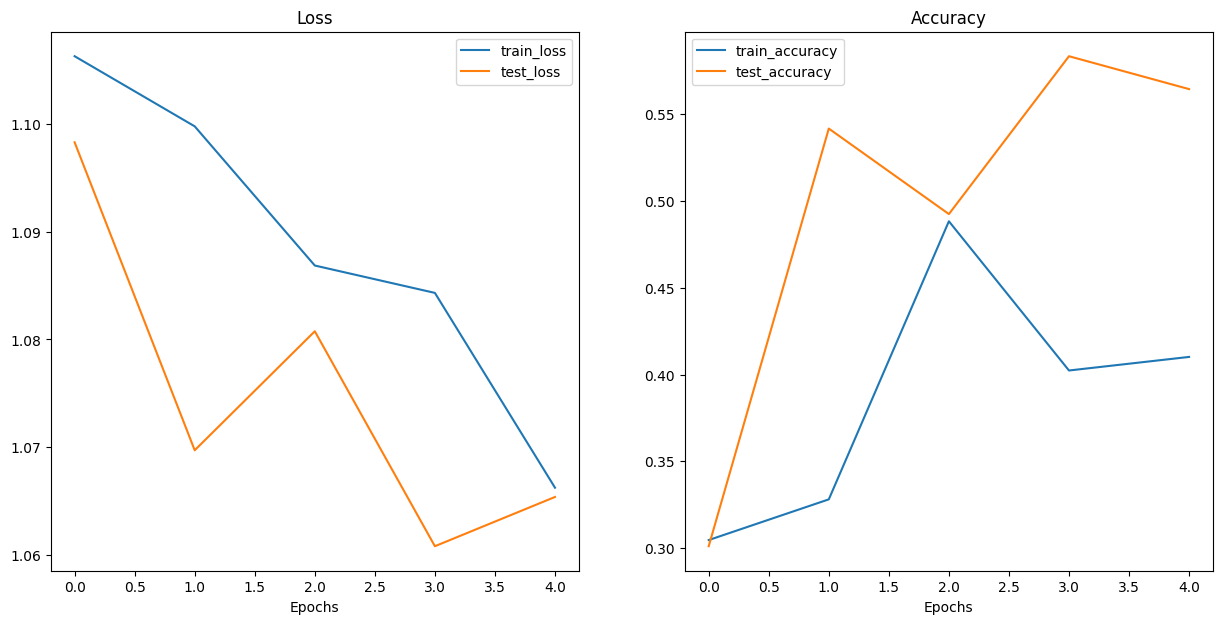

In [90]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

https://developers.google.com/machine-learning/testing-debugging

A loss curve is one of the most helpful ways to troubleshoot a model.

## 9. Model 1: TinyVGG with data augmentation

Now let's try another modelling experiment this time using the same model as before but with some data augmentation.

### 9.1 Create transform with data augmentation

In [91]:
# CReate training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    # transforms.TrivialAugmentWide(num_magnitude_bins = 31), We dont apply data augmentation to test dataset
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [92]:
# Turn image folder into datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root = train_dir,
                                            transform = train_transform_trivial,
                                            target_transform = None)

test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform = test_transform_simple)

In [93]:
# Turn our datasets into data loaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size = BATCH_SIZE,
                                        num_workers = NUM_WORKERS,
                                        shuffle = True)
test_dataloader_augmented = DataLoader(test_data_simple,
                                       batch_size = BATCH_SIZE,
                                       num_workers = NUM_WORKERS,
                                       shuffle = False)

### 9.3 Construct and train model

This time we'll be using same model architecture except this time we've augmented the training data.

In [103]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape = 3,
                  hidden_units = 16,
                  output_shape = len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2704, out_features=3, bias=True)
  )
)

Wonderful! Now we've a model and dataloaders, let's create a loss function and an optimizer and call upon our `train()` function to train adn evaluate our model.

In [104]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                             lr = 0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model = model_1,
                        train_dataloader = train_dataloader_augmented,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS,
                        device = device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.0797 | Train acc: 0.3789 | Test acc: 0.5644
Epoch: 1 | Train loss: 1.0942 | Train acc: 0.4258 | Test acc: 0.5644
Epoch: 2 | Train loss: 1.0546 | Train acc: 0.4258 | Test acc: 0.5644
Epoch: 3 | Train loss: 1.0557 | Train acc: 0.5156 | Test acc: 0.5644
Epoch: 4 | Train loss: 1.0606 | Train acc: 0.4219 | Test acc: 0.5644
Total training time for model_1: 5.320 seconds


### 9.4 Plot the loss curves of model 1
A loss curve helps you evaluate your model's performance overtime.

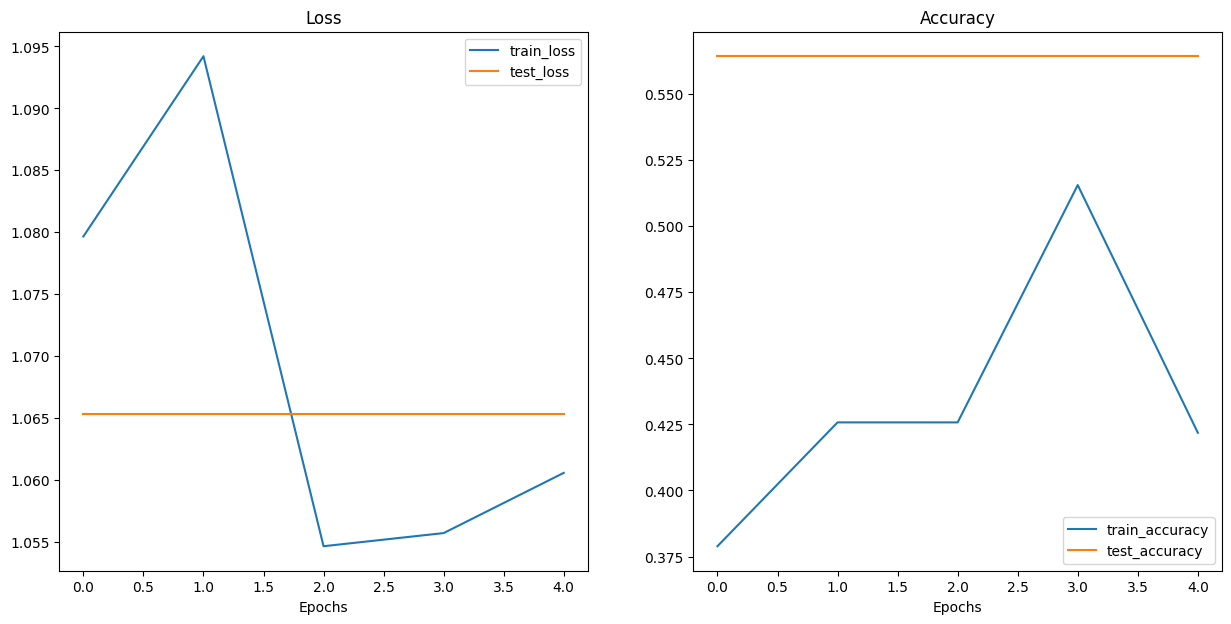

In [102]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After evaluatin gour modelling experiments on their own it's important to compare them to each other.

There's a few different ways to do this:
1. Hard coding (What we're doing)
2. PyTorch + Tensorboard
3. Weights & Biases
4. MLFlow                

In [106]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098321,0.301136
1,1.099803,0.328125,1.069699,0.541667
2,1.086868,0.488281,1.080757,0.492424
3,1.084324,0.402344,1.060781,0.583333
4,1.066221,0.410156,1.065358,0.564394


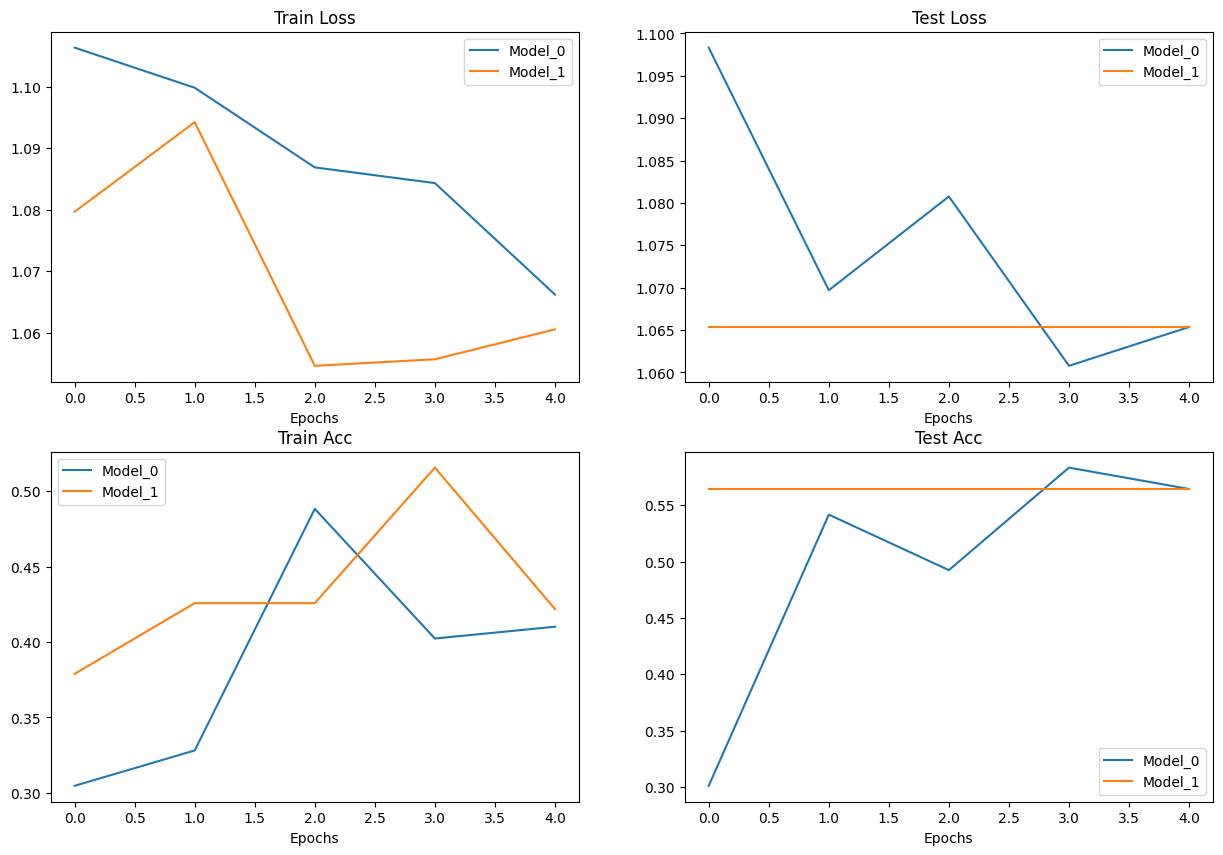

In [113]:
# Setup a plot
plt.figure(figsize = (15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label = "Model_0")
plt.plot(epochs, model_1_df["train_loss"], label = "Model_1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()


# Plot train loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label = "Model_0")
plt.plot(epochs, model_1_df["test_loss"], label = "Model_1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train loss
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label = "Model_0")
plt.plot(epochs, model_1_df["train_acc"], label = "Model_1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()


# Plot train loss
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label = "Model_0")
plt.plot(epochs, model_1_df["test_acc"], label = "Model_1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## 11. Making a prediction on a custom image

Although we've trained a model on custom data... How do you make a prediction on a sample/image that's not in either trainig or testing dataset.

In [ ]:
# Download custom image
import requests

# Setup custim image path
custom_image_path = data_path/'04-pizza-dad.jpeg'

# Download the image if it doesn't already exists
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    # When downloading from github, need to use the "raw" file link
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/04-pizza-dad.jpeg')
    print(f'Downloading {custom_image_path}...')
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")